In [20]:
import numpy as np
import h5py

f = h5py.File('./scatoneimage.mat','r')
imagen = np.array(f['image']).transpose()
joan_scat = np.array(f['feature'])

[ 0.0 , 255.0 ]


array([848,   0,   4,   1,   2,   0,   0,   1,   1,   2,   2,   1,   0,
         0,   2,   0,   0,   0,   5,   4,   1,   1,   2,   1,   1,   0,
         0,   2,   0,   2,   1,   0,   2,   7,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   1,   2,   0,   1,   1,   0,   1,   2,   0,
         1,   0,   1,   0,   3,   1,   0,   0,   0,   2,   1,   1,   5,
         1,   0,   1,   0,   3,   0,   0,   1,   3,   0,   2,   3,   1,
         1,   0,   1,   0,   0,   1,   0,   0,   3,   3,   3,   1,   3,
         0,   6,   1,   1,   1,   1,  41,  25])

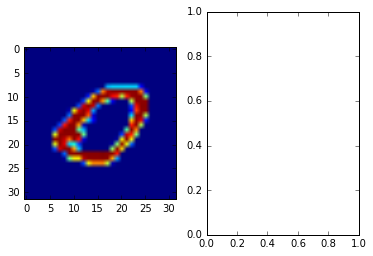

In [42]:
%matplotlib inline
import matplotlib.pylab as plt
plt.subplot(1,2,1)
plt.imshow(imagen)
print('[',np.min(imagen),',',np.max(imagen),']')
plt.subplot(1,2,2)
h=np.histogram(imagen[:],bins=np.linspace(0, 255, 100))
#plt.plot(h[0],h[1])
#plt.show()
h[0]

In [18]:
from scattering.filter_bank import filter_bank_morlet2d
from scattering.scattering import scattering

J=3
L=6
px=32
wavelet_filters, littlewood = filter_bank_morlet2d(px, J=J, L=L)
S = scattering(imagen[np.newaxis,:,:], wavelet_filters)
myscat = S[0][0,:,:,:]
myscat.shape=(myscat.shape[0]*myscat.shape[1]*myscat.shape[2])

/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:] = np.fft.rfft(img, axis=-1) * phi[0, :N_nolp_r].reshape(1, N_nolp_r)


In [19]:
myscat.shape

(8128,)

In [21]:
print(myscat.shape)
print(joan_scat.shape)

(8128,)
(8128, 1)


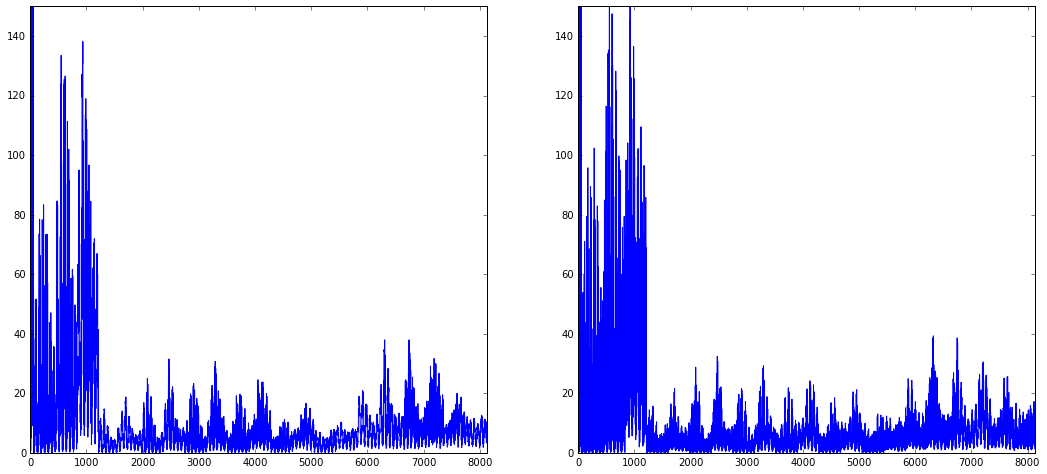

In [23]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(myscat)
plt.axis([0,8128, 0, 150])
plt.subplot(1,2,2)
plt.plot(joan_scat)
plt.axis([0,8128, 0, 150])
plt.show()

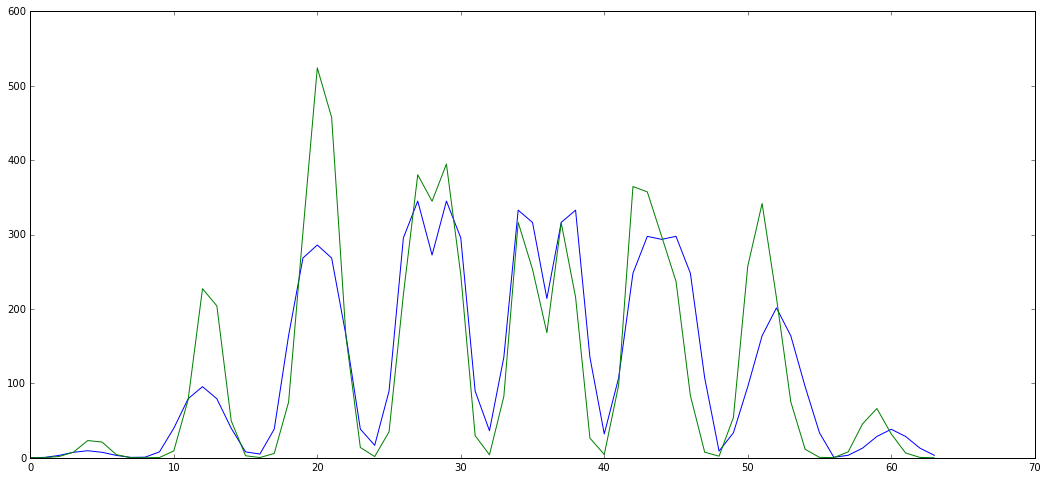

In [54]:
vj = joan_scat[0:64]
vm = myscat[0:64]
n = np.arange(0,64)
plt.figure(figsize=(18,8))
#plt.subplot(1,3,1)
plt.plot(n,vm,n,vj)
#plt.axis([0,64, 0, 150])
#plt.subplot(1,3,2)
#plt.plot(n,vj)
#plt.axis([0,64, 0, 150])
#plt.subplot(1,3,3)
#plt.plot(vj,vm,'*')
#plt.axis([0,300,0,300])

plt.show()

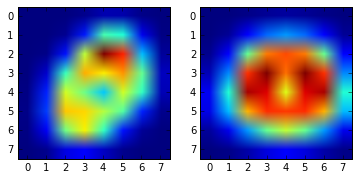

In [56]:
plt.subplot(1,2,1)
plt.imshow(np.reshape(vj,(8,8)))
plt.subplot(1,2,2)
plt.imshow(np.reshape(vm,(8,8)))
plt.show()

In [ ]:
def apply_lowpass(img, phi, J, N_scat):
    # NB: I could compute N_scat here, but in case we want to oversample, this
    # may be useful. I should make a class.

    #This function can be applied to a set of images and angles, the input img is assumed
    #to be of size (num_images,L,size_x,size_y)

    N_nolp = img.shape[-1]

    N_nolp_r = N_nolp // 2 + 1
    dsf = N_nolp / N_scat

    # out will in the end point to a downsampled lowpassed image
    # out = ifft(fft(img, axis=1)
    #    * phi[0, :].reshape(1, N_nolp), axis=1)[:, ::dsf]

    # TO DO: use real transforms
    out = np.zeros((img.shape[:-1] + (N_nolp_r, 1)))
    out.shape = out.shape[:-1]
    # out = np.zeros((img.shape[0],img.shape[1], N_nolp_r))
    out[:] = np.fft.rfft(img, axis=-1) * phi[0, :N_nolp_r].reshape(1, N_nolp_r)

    out = np.fft.irfft(out, axis=-1)[..., ::dsf].copy()
    out = np.fft.rfft(out, axis=-2) * phi[:N_nolp_r, 0].reshape(N_nolp_r, 1)
    out = np.fft.irfft(out, axis=-2)[..., ::dsf, :]
    out = 2 ** (J - 1) * np.real(out)

    return out

In [58]:
from scattering.scattering import apply_lowpass
#Zero order coeffs
spatial_coefs = 8
Scero= apply_lowpass(imagen, wavelet_filters['phi'][0], J,  spatial_coefs)

/Users/ferradans/Documents/Research/ScatteringPython/scattering/scattering/scattering.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:] = np.fft.rfft(img, axis=-1) * phi[0, :N_nolp_r].reshape(1, N_nolp_r)


In [74]:
np.linspace(0,32,9)

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.])

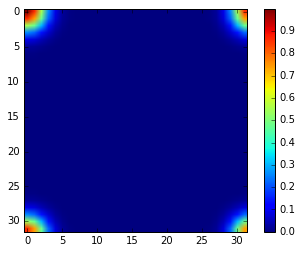

In [97]:
f = h5py.File('./joanphi.mat','r')
joanphi = np.array(f['phi']).transpose()
plt.imshow(joanphi)
plt.colorbar()
plt.show()

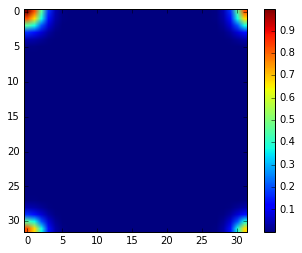

In [98]:
phimio=wavelet_filters['phi'][0]
plt.imshow(np.abs(phimio))
plt.colorbar()
plt.show()

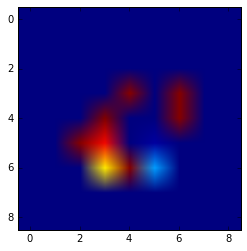

In [91]:
v = np.linspace(0,31,9).astype('int')
iv =imagen[v,:]
im = iv[:,v]

plt.subplot(1,2,1)
plt.imshow(im)
plt.show()